<a href="https://colab.research.google.com/github/NeuromatchAcademy/course-content/blob/W1D1/tutorials/W1D1-ModelTypes/W1D1_Tutorial2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  NMA Model Types Tutorial 2: "How" models

In this tutorial we will explore models that can potentially explain *how* the spiking data we have observed is produced. That is, the models will tell us something about the *mechanism* underlying the physiological phenomenon.

Our objectives:
- Write code to simulate a  simple "leaky integrate-and-fire" neuron model
- Make the model more complicated — but also more realistic — by adding more physiologically-inspired details

Video available at https://youtube.com/watch?v=cXKna34K1P4


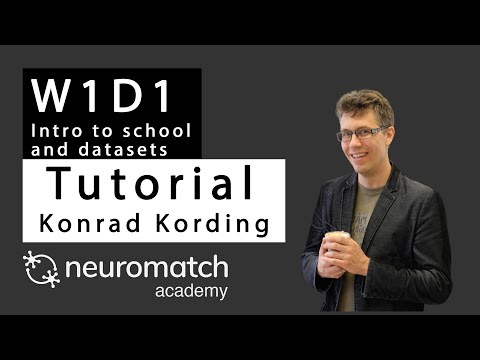

In [1]:
#@title Video: "How" models
from IPython.display import YouTubeVideo
video = YouTubeVideo(id='cXKna34K1P4', width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)
video

## Setup

**Don't forget to execute the hidden cells!**

In [2]:
#@title Imports
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

import ipywidgets as widgets

In [3]:
#@title Helper Functions
def histogram(counts, bins, vlines=(), ax=None, ax_args=None, **kwargs):
  """Plot a step histogram given counts over bins."""
  if ax is None:
    _, ax = plt.subplots()
    
  # duplicate the first element of `counts` to match bin edges
  counts = np.insert(counts, 0, counts[0])

  ax.fill_between(bins, counts, step="pre", alpha=0.4, **kwargs)  # area shading
  ax.plot(bins, counts, drawstyle="steps", **kwargs)  # lines

  for x in vlines:
    ax.axvline(x, color='r', linestyle='dotted')  # vertical line

  if ax_args is None:
    ax_args = {}

  # heuristically set max y to leave a bit of room
  ymin, ymax = ax_args.get('ylim', [None, None])
  if ymax is None: 
    ymax = np.max(counts)
    if ax_args.get('yscale', 'linear') == 'log':
      ymax *= 1.5
    else:
      ymax *= 1.1
      if ymin is None:
        ymin = 0

  if ymax == ymin:
    ymax = None
  
  ax_args['ylim'] = [ymin, ymax]
  
  ax.set(**ax_args)
  ax.autoscale(enable=False, axis='x', tight=True)


def plot_neuron_stats(v, spike_times):
  fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5))
  
  # membrane voltage trace  
  ax1.plot(v[0:100])
  ax1.set(xlabel='Time', ylabel='Voltage')
  # plot spike events
  for x in spike_times:
    if x >= 100:
      break
    ax1.axvline(x, color='limegreen')

  # ISI distribution 
  isi = np.diff(spike_times)
  n_bins = bins = np.arange(isi.min(), isi.max() + 2) - .5
  counts, bins = np.histogram(isi, bins)
  vlines = []
  if len(isi) > 0:
    vlines = [np.mean(isi)]    
  xmax = max(20, int(bins[-1])+5)
  histogram(counts, bins, vlines=vlines, ax=ax2, ax_args={
    'xlabel': 'Inter-spike interval',
    'ylabel': 'Number of intervals',
    'xlim': [0, xmax]
  }) 

## The Linear Integrate-and-Fire Neuron

One of the simplest models of spiking neuron behavior is the linear integrate-and-fire model neuron. In this model, the neuron increases its membrane potential $V_m$ over time in response to excitatory input currents $I$ scaled by some factor $\alpha$:

\begin{align}
  dV_m = {\alpha}I
\end{align}

Once $V_m$ reaches a threshold value of 1, a spike is emitted, the neuron resets $V_m$ back to 0, and the process continues.

#### Spiking Inputs

We now have a model for the neuron dynamics. Next we need to consider what form the input $I$ will take. How should we represent the presynaptic neuron firing behavior providing the input coming into our model nueuron? We learned previously that a good approximation of spike timing is a Poisson random variable, so we can do that here as well

\begin{align}
  I \sim Poisson(\lambda)
\end{align}

where $\lambda$ is the average rate of incoming spikes.

### Exercise: Compute $dV_m$

For your first exercise, you will write the code to compute the change in voltage $dV_m$ of the linear integrate-and-fire model neuron. The rest of the code to handle the neuron dynamics are provided for you, so you just need to fill in a definition for `dv` in the `lif_neuron` method below. The value for $\lambda$ needed for the Poisson random variable is named `rate`.

TIP: The [`scipy.stats`](https://docs.scipy.org/doc/scipy/reference/stats.html) package is a great resource for working with and sampling from various probability distributions.

In [4]:
def lif_neuron(n_steps=1000, alpha=0.01, rate=10):
  """ Simulate a linear integrate-and-fire neuron.

  Args:
    n_steps (int): The number of time steps to simulate the neuron's activity.
    alpha (float): The input scaling factor
    rate (int): The mean rate of incoming spikes

  """
  v = np.zeros(n_steps)
  spike_times = []
  for i in range(1, n_steps):

    #######################################################################
    ## TODO for students: compute dv, then remove the NotImplementedError #
    #######################################################################
    # dv = ...
    raise NotImplementedError("Student excercise: compute the change in membrane potential")

    v[i] = v[i-1] + dv
    if v[i] > 1:
      spike_times.append(i)
      v[i] = 0
  
  return v, spike_times

# Uncomment these lines after completing the lif_neuron function
# v, spike_times = lif_neuron()
# plot_neuron_stats(v, spike_times)

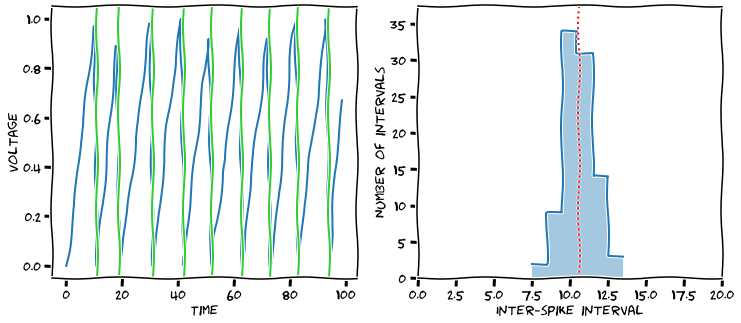

In [5]:
# to_remove solution
def lif_neuron(n_steps=1000, alpha=0.01, rate=10):
  """ Simulate a linear integrate-and-fire neuron.
  
  Args:
    n_steps (int): The number of time steps to simulate the neuron's activity.
    alpha (float): The input scaling factor
    rate (int): The mean rate of incoming spikes
  """
  # precompute Poisson samples for speed
  exc = stats.poisson(rate).rvs(n_steps)

  v = np.zeros(n_steps)
  spike_times = []
  for i in range(1, n_steps):
    dv = alpha * exc[i]
    v[i] = v[i-1] + dv
    if v[i] > 1:
      spike_times.append(i)
      v[i] = 0

  return v, spike_times

v, spike_times = lif_neuron()
with plt.xkcd():
  plot_neuron_stats(v, spike_times)

### Parameter Exploration

Here's an interactive demo that shows how the model behavior changes for different parameter values.

**Remember to enable the demo by running the cell.**

In [6]:
#@title Linear Integrate-and-Fire Model Neuron Explorer

def _lif_neuron(n_steps=1000, alpha=0.01, rate=10):
  exc = stats.poisson(rate).rvs(n_steps)
  v = np.zeros(n_steps)
  spike_times = []
  for i in range(1, n_steps):
    dv = alpha * exc[i]
    v[i] = v[i-1] + dv
    if v[i] > 1:
      spike_times.append(i)
      v[i] = 0
  return v, spike_times

@widgets.interact(
  n_steps=widgets.FloatLogSlider(1000.0, min=2, max=4),
  alpha=widgets.FloatLogSlider(0.01, min=-4, max=-1),
  rate=widgets.IntSlider(10, min=1, max=20)
)
def plot_lif_neuron(n_steps=1000, alpha=0.01, rate=10):
  v, spike_times = _lif_neuron(int(n_steps), alpha, rate)
  plot_neuron_stats(v, spike_times)

interactive(children=(FloatLogSlider(value=1000.0, description='n_steps', min=2.0), FloatLogSlider(value=0.01,…

## Inhibitory signals

Our linear integrate-and-fire neuron from the previous section was indeed able to produce spikes, but the actual spiking behavior did not line up with our expectations of exponentially distributed ISIs. This means we need to refine our model!

In the previous model we only considered excitatory behavior -- the only way the membrane potential could decrease is upon a spike event. We know, however, that there are other factors that can drive $V_m$ down. First is the natural tendancy of the neuron to return to some steady state or resting potential. We can update our previous model as follows:

\begin{align}
  dV_m = -{\beta}V_m + {\alpha}I
\end{align}

where $V_m$ is the current membrane potential and $\beta$ is some leakage factor. This is a basic form of the popular Leaky Integrate-and-Fire model neuron (for a more detailed discussion of the LIF Neuron, see the Appendix).

We also know that in addition to excitatory presynaptic neurons, we can have inhibitory presynaptic neurons as well. We can model these inhibitory neurons with another Poisson random variable, giving us

\begin{align}
I = I_{exc} - I_{inh} \\
I_{exc} \sim Poisson(\lambda_{exc}) \\
I_{inh} \sim Poisson(\lambda_{inh})
\end{align}

where $\lambda_{exc}$ and $\lambda_{inh}$ are the rates of the excitatory and inhibitory presynaptic neurons, respectively.

### Exercise: Compute $dV_m$ with inhibitory signals

For your second exercise, you will again write the code to compute the change in voltage $dV_m$, though now of the LIF model neuron described above. Like last time, the rest of the code needed to handle the neuron dynamics are provided for you, so you just need to fill in a definition for `dv` below.


In [7]:
def lif_neuron_inh(n_steps=1000, alpha=0.5, beta=0.1, exc_rate=10, inh_rate=10):
  """ Simulate a simplified leaky integrate-and-fire neuron with both excitatory
  and inhibitory inputs.
  
  Args:
    n_steps (int): The number of time steps to simulate the neuron's activity.
    alpha (float): The input scaling factor
    beta (float): The membrane potential leakage factor
    exc_rate (int): The mean rate of the incoming excitatory spikes
    inh_rate (int): The mean rate of the incoming inhibitory spikes
  """
  v = np.zeros(n_steps)
  spike_times = []
  for i in range(1, n_steps):

    ############################################################
    ## Students: compute dv and remove the NotImplementedError #
    ############################################################
    # dv = ...
    raise NotImplementedError("Student excercise: compute the change in membrane potential")

    v[i] = v[i-1] + dv
    if v[i] > 1:
      spike_times.append(i)
      v[i] = 0

  return v, spike_times

# Uncomment these lines do make the plot once you've completed the function
# v, spike_times = lif_neuron_inh()
# plot_neuron_stats(v, spike_times)

In [8]:
# to_remove solution
def lif_neuron_inh(n_steps=1000, alpha=0.5, beta=0.1, exc_rate=10, inh_rate=10):
  """ Simulate a simplified leaky integrate-and-fire neuron with both excitatory
  and inhibitory inputs.
  
  Args:
    n_steps (int): The number of time steps to simulate the neuron's activity.
    alpha (float): The input scaling factor
    beta (float): The membrane potential leakage factor
    exc_rate (int): The mean rate of the incoming excitatory spikes
    inh_rate (int): The mean rate of the incoming inhibitory spikes
  """
  # precompute Poisson samples for speed
  exc = stats.poisson(exc_rate).rvs(n_steps)
  inh = stats.poisson(inh_rate).rvs(n_steps)

  v = np.zeros(n_steps)
  spike_times = []
  for i in range(1, n_steps):
    dv = -beta * v[i-1] + alpha * (exc[i] - inh[i])
    v[i] = v[i-1] + dv
    if v[i] > 1:
      spike_times.append(i)
      v[i] = 0

  return v, spike_times

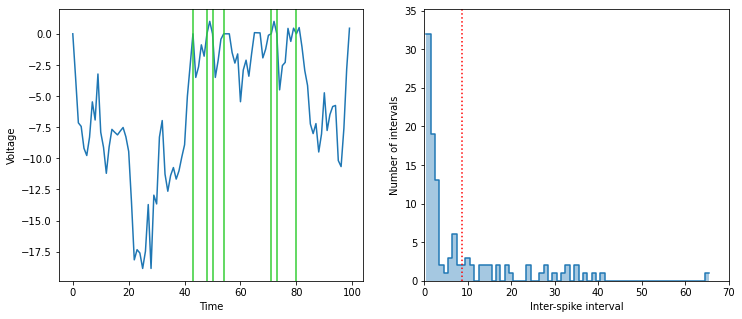

In [9]:
v, spike_times = lif_neuron_inh()
plot_neuron_stats(v, spike_times)

### Parameter Exploration

Like last time, you can now explore how you LIF model behaves when the various parameters of the system are changed.

In [10]:
#@title LIF Model Neuron with Inhibitory Inputs Explorer

def _lif_neuron_inh(n_steps=1000, alpha=0.5, beta=0.1, exc_rate=10, inh_rate=10):
  """ Simulate a simplified leaky integrate-and-fire neuron with both excitatory
  and inhibitory inputs.
  
  Args:
    n_steps (int): The number of time steps to simulate the neuron's activity.
    alpha (float): The input scaling factor
    beta (float): The membrane potential leakage factor
    exc_rate (int): The mean rate of the incoming excitatory spikes
    inh_rate (int): The mean rate of the incoming inhibitory spikes
  """
  # precompute Poisson samples for speed
  exc = stats.poisson(exc_rate).rvs(n_steps)
  inh = stats.poisson(inh_rate).rvs(n_steps)

  v = np.zeros(n_steps)
  spike_times = []
  for i in range(1, n_steps):
    dv = -beta * v[i-1] + alpha * (exc[i] - inh[i])
    v[i] = v[i-1] + dv
    if v[i] > 1:
      spike_times.append(i)
      v[i] = 0

  return v, spike_times

@widgets.interact(n_steps=widgets.FloatLogSlider(1000.0, min=2, max=4),
                  alpha=widgets.FloatLogSlider(0.5, min=-2, max=1),
                  beta=widgets.FloatLogSlider(0.1, min=-2, max=0),
                  exc_rate=widgets.IntSlider(10, min=1, max=20),
                  inh_rate=widgets.IntSlider(10, min=1, max=20))
def plot_lif_neuron(n_steps=1000, alpha=0.5, beta=0.1, exc_rate=10, inh_rate=10):
  v, spike_times = _lif_neuron_inh(int(n_steps), alpha, beta, exc_rate, inh_rate)
  plot_neuron_stats(v, spike_times)

interactive(children=(FloatLogSlider(value=1000.0, description='n_steps', min=2.0), FloatLogSlider(value=0.5, …

Video available at https://youtube.com/watch?v=buXEQPp9LKI


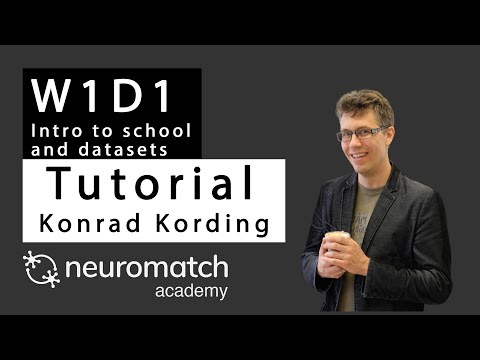

In [11]:
#@title Video: Balanced inputs
from IPython.display import YouTubeVideo
video = YouTubeVideo(id='buXEQPp9LKI', width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)
video

## Appendix

### Why do neurons spike?

A neuron stores energy in an electric field across its cell membrane, by controlling the distribution of charges (ions) on either side of the membrane. This energy is rapidly discharged to generate a spike when the field potential (or membrane potential) crosses a threshold. The membrane potential may be driven toward or away from this threshold, depending on inputs from other neurons: excitatory or inhibitory, respectively. The membrane potential tends to revert to a resting potential, for example due to the leakage of ions across the membrane, so that reaching the spiking threshold depends not only on the amount of input ever received following the last spike, but also the timing of the inputs.

The storage of energy by maintaining a field potential across an insulating membrane can be modeled by a capacitor. The leakage of charge across the membrane can be modeled by a resistor. This is the basis for the leaky integrate-and-fire neuron model.

### The LIF Model Neuron

The full equation for the LIF neuron is

\begin{align}
C_{m}\frac{dV_m}{dt} = -(V_m - V_{rest})/R_{m} + I
\end{align}

where $C_m$ is the membrane capacitance, $R_M$ is the membrane resistance, $𝑉_{𝑟𝑒𝑠𝑡}$ is the resting potential, and  𝐼  is some input current (from other neurons, an electrode, ...).

In our above examples we set many of these properties to convenient values ($C_m = R_m = dt = 1$, $V_{rest} = 0$) to focus more on the overall behavior, though these too can be manipulated to achieve different dynamics.